In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Constants in SI system

# Gravitational constant
G = 6.67430e-11
# Solar mass
M_sun = 1.989e30

# Unit Conversions
kpc_km = 3.086e16
kpc_m = kpc_km * 1000
kms_ms = 1000

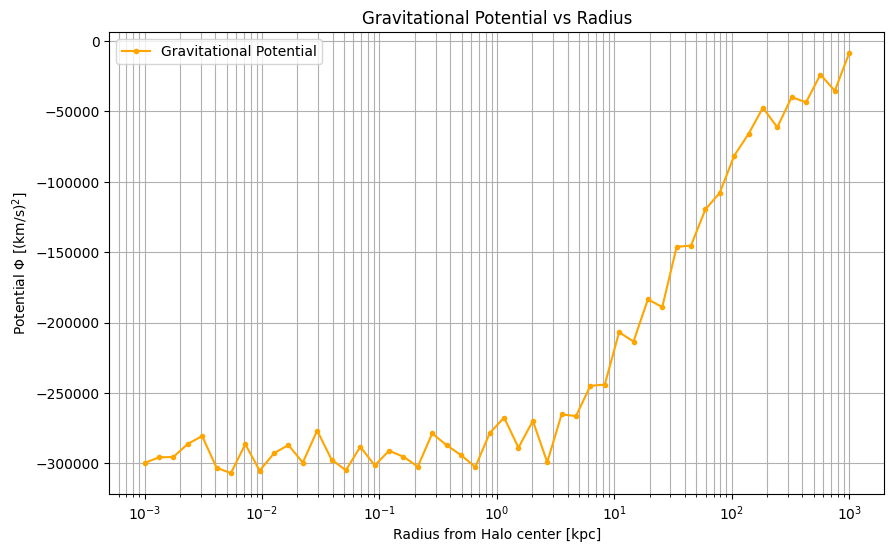

In [ ]:
# 1) Reading data from the file

data = np.loadtxt('halo_potential.txt')
r_kpc = data[:, 0]    # Column 1: Radius in kpc
pot = data[:, 1]      # Column 2: Potential in (km/s)^2

# Plotting gravitational potential
plt.figure(figsize=(10, 6))
plt.plot(r_kpc, pot, label='Gravitational Potential', color='orange', alpha=1, marker='.')
plt.xscale('log')
plt.xlabel('Radius from Halo center [kpc]')
plt.ylabel(r'Potential [(km/s)$^2$]')
plt.title('Gravitational Potential vs Radius')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

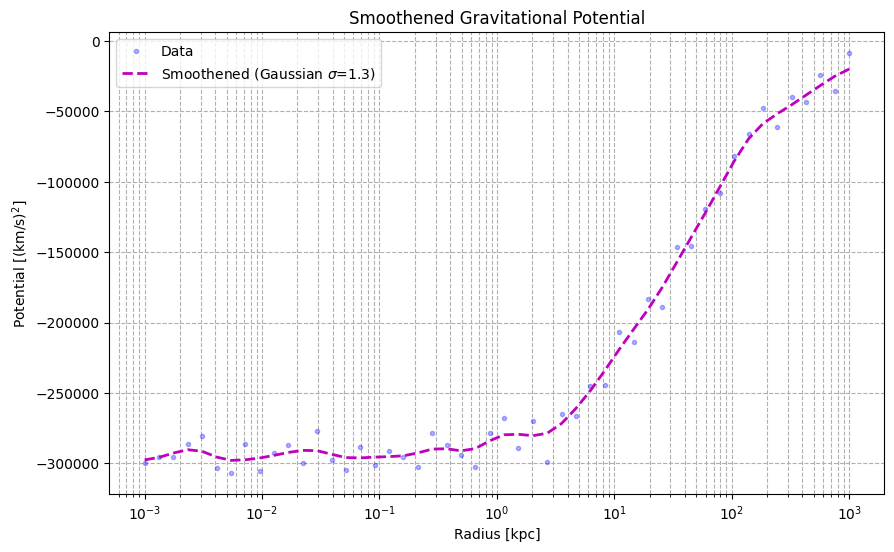

In [ ]:
# 2) Smoothing the data

sigma = 1.3  # standart deviation for Gaussian
pot_smooth = gaussian_filter1d(potential, sigma=sigma)

# Plots
plt.figure(figsize=(10, 6))
plt.plot(r_kpc, potential, 'b.', alpha=0.3, label='Data')

plt.plot(r_kpc, pot_smooth, 'm--', linewidth=2, label=rf'Smoothed (Gaussian $\sigma$={sigma})')

plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel(r'Potential [(km/s)$^2$]')
plt.title('Smoothed Gravitational Potential')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

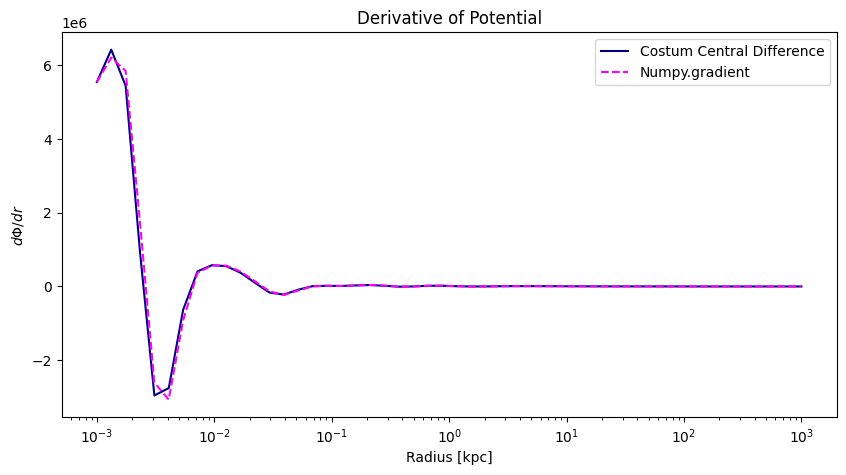

In [49]:
# 3) Calculate derivative dPhi/dr using custom central difference

def central_difference_derivative(x, y):

    # Calculates the derivative dy/dx using the central difference method.

    n = len(x)
    dydx = np.zeros(n)

    # Interior points: Central Difference
    # approximate f'(x_i) ~ (y_{i+1} - y_{i-1}) / (x_{i+1} - x_{i-1})
    for i in range(1, n-1):
        dydx[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])

    # Boundary points: Forward/Backward difference
    dydx[0] = (y[1] - y[0]) / (x[1] - x[0])       # Forward difference for first point
    dydx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])  # Backward difference for last point

    return dydx

# Calculate derivative of the smoothed potential
dPhi_dr = central_difference_derivative(r_kpc, pot_smooth)

# Comparing with numpy.gradient
numpy_grad = np.gradient(pot_smooth, r_kpc)

# Visualization of derivative
plt.figure(figsize=(10, 5))
plt.plot(r_kpc, dPhi_dr, label='Costum Central Difference', color='navy')
plt.plot(r_kpc, numpy_grad, '--', label='Numpy.gradient', color='magenta')
plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel(r'$d\Phi/dr$')
plt.title('Derivative of Potential')
plt.legend()
plt.show()

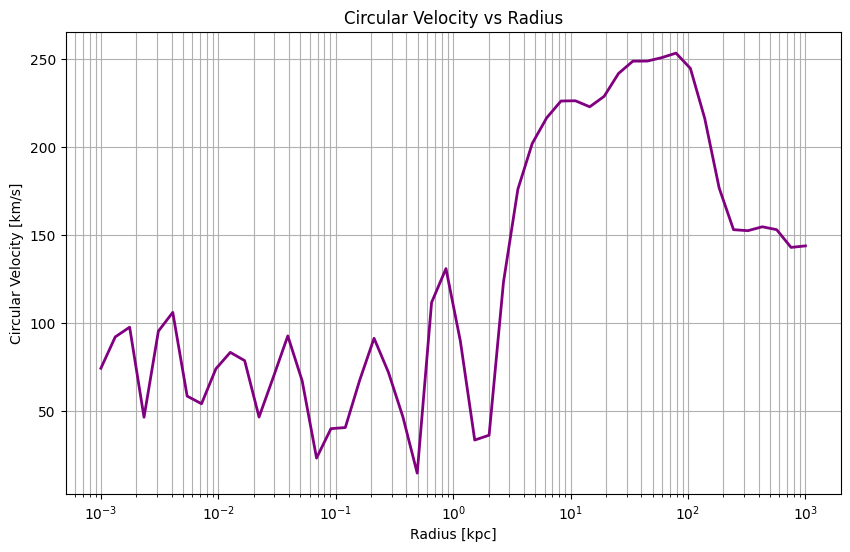

In [63]:
# 4) Calculate circular velocity v_c
# v_c = sqrt(r * dPhi/dr)

v_c = np.sqrt(np.abs(r_kpc * dPhi_dr))

# Plot v_c
plt.figure(figsize=(10, 6))
plt.plot(radius_kpc, v_c, color='purple', linewidth=2)
plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('Circular Velocity [km/s]')
plt.title('Circular Velocity vs Radius')
plt.grid(True, which="both", ls="-")
plt.show()

In [67]:
# 5) Find maximum circular velocity and radius
max_idx = np.argmax(v_c)
vc_max = v_c[max_idx]
rc_max = r_kpc[max_idx]

print(f"Maximum Circular Velocity (vc_max): {vc_max:.2f} km/s")
print(f"Radius at max velocity (rc_max): {rc_max:.3f} kpc")

#Calculate Mass Enclosed at rc_max
# Formula: M = (v^2 * r) / G
# We must convert units to SI to get Mass in kg, then convert to Solar Masses.

def calculate_enclosed_mass(v_kms, r_kpc):
    v_si = v_kms * kms_ms          # Convert to m/s
    r_si = r_kpc * kpc_m           # Convert to meters
    mass_kg = (v_si**2 * r_si) / G # Mass in kg
    mass_solar = mass_kg / M_sun   # Mass in Solar Masses
    return mass_solar

M_max = calculate_enclosed_mass(vc_max, rc_max)

print(f"Total Mass enclosed within {rc_max:.3f} kpc: {M_max:.2e} Solar Masses")

Maximum Circular Velocity (vc_max): 253.34 km/s
Radius at max velocity (rc_max): 79.060 kpc
Total Mass enclosed within 79.060 kpc: 1.18e+12 Solar Masses


In [72]:
# 6) Interpolation

target_r = 10.0 # kpc

# Create interpolation function for Velocity

f_interp = interp1d(r_kpc, v_c, kind='cubic')

vc_10kpc = f_interp(target_r)

print(f"\nInterpolated Circular Velocity at r = {target_r} kpc: {vc_10kpc:.2f} km/s")

#Calculate halo mass enclosed within 10 kpc
M_10kpc = calculate_enclosed_mass(vc_10kpc, target_r)

print(f"Halo Mass enclosed within {target_r} kpc: {M_10kpc:.2e} Solar Masses")

# Comparison
print("-" * 30)
print(f"Mass at r_max ({rc_max:.2f} kpc): {M_max:.2e} M_sun")
print(f"Mass at edge ({target_r:.2f} kpc):  {M_10kpc:.2e} M_sun")


Interpolated Circular Velocity at r = 10.0 kpc: 227.37 km/s
Halo Mass enclosed within 10.0 kpc: 1.20e+11 Solar Masses
------------------------------
Mass at r_max (79.06 kpc): 1.18e+12 M_sun
Mass at edge (10.00 kpc):  1.20e+11 M_sun
